In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from utils import subconjuntos_de, obtener_conjuntos_base

# Trayectorias profesionales

Uno de los frentes de la etapa LLL consiste en trazar trayectorias de desarrollo profesional en base a las habilidades y conocimientos requeridos por los diferentes cargos. El modelo sueño comenzaría con un set inicial de skills en base al cual recomendaría posiciones a las cuales acceder si se aprende alguna cantidad de skills adicionales, y luego caminos adicionales que seguir de forma consecutiva.

Se tienen datos de posiciones laborales (job titles) y tecnologías requeridas para el cargo según la base de datos [Onet](https://www.onetonline.org/). En base a estas se construirá la matriz de skills

## Carga y generación de datos

In [3]:
# Carga de datos
df = pd.read_excel("Technology Skills.xlsx")

In [4]:
# Se almacenan los títulos
all_titles = pd.Series(df["Title"].dropna().unique())
# Sólo se almacenan las tecnologías que se requieren para al menos 2 job titles
all_technologies = pd.Series(df["Example"].value_counts()[df["Example"].value_counts()>1].index)
# Se crean objetos tipo series de pandas para pasar del título al índice
all_titles_ind = pd.Series(all_titles.index, index = all_titles)
all_technologies_ind = pd.Series(all_technologies.index, index = all_technologies)
#Cantidad de títulos, cantidad de tecnologías
all_titles.shape[0], all_technologies.shape[0]

(923, 2622)

Creación de matriz de titles / skills. Esta corresponde a una matriz binaria de forma (N° títulos, N° tecnologías), donde un 1 indica que el título requiere la tecnología y un 0 indica que no.

In [5]:
# Se inicializa la matriz como ceros
X = np.zeros((all_titles.shape[0], all_technologies.shape[0]))

# Se itera por cada título
for title in all_titles:
    # Tecnologías asociadas al título
    title_technologies = df[df["Title"] == title]["Example"]
    # Se filtra por aquellas que tienen al menos 2 títulos
    title_technologies = title_technologies[title_technologies.isin(all_technologies)]
    # Se le asigna el valor 1 a las tecnologías requeridas por el título
    X[all_titles_ind[title], all_technologies_ind[title_technologies]] = 1


Al no tener de momento el salario promedio, este se generará aleatoreamente en base a la cantidad de tecnologías requeridas por un título.

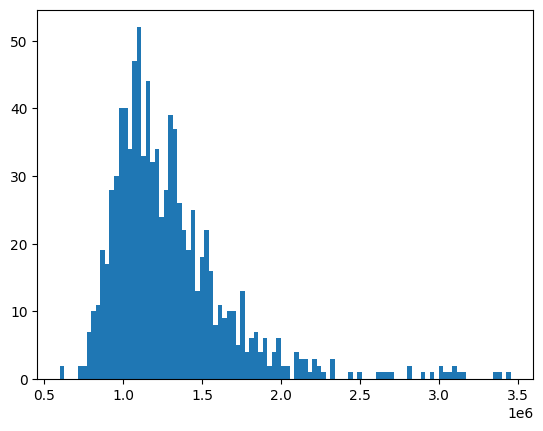

In [6]:
# El salario promedio es una función de la cantidad de skills que tiene un título.
salario_promedio = ((np.sqrt(X.sum(axis = 1)) * (150 + 10*np.random.randn(X.shape[0]))+ 600)*1000).round(-2)
plt.hist(salario_promedio, bins = 100)
pass

## Heuristica de trayectorias profesionales

### Approach 1

El primer approach utiliza una heurística en base a los conjuntos base. Si se toman skills como punto de partida y se obtiene la matriz de las skills **faltantes** para llegar a cada empleo, los conjuntos base de esta matriz son aquellos empleos que no tienen intermediarios, es decir, que para llegar a ese empleo, no existe ningún otro empleo al cual deba llegar primero.

In [7]:
def pathway_iteration(skills_input, matriz):
    """
    Corresponde a una iteración del primer approach de heurística de trayectorias. Se toma un
    conjunto de skills de partida y una matriz de forma (n_empleos, n_skills). Se buscan los empleos
    que corresponden al siguiente paso como los conjuntos base de la matriz de skills que faltan
    para llegar a cada empleo, agrupando duplicados en nodos.

    Parámetros
    ----------
        skills_input: numpy.ndarray de forma (n_skills,)
            Vector binario con las skills de partida
        matriz: numpy.ndarray binario de forma (n_empleos, n_skills)
            Matriz binaria con el skillset de todos los empleos a analizar
        
    Retorna
    -------
    skills acumuladas: numpy.ndarray de forma (n_nodos, n_skills)
        Matriz con las skills que se tendrían luego de avanzar a cada nodo
    indices: list
        Lista de listas de forma (n_nodos, *) con los índices de todos los empleos de la matriz
        que pertenecen a cada nodo
    distancias: list
        Lista de forma (n_nodos, ) con el N° de skills requeridos para avanzar a cada nodo. 
    """
    # Matriz de skills faltantes para cada empleo: skills ausentes de skills_input y presentes en matriz
    matriz_diff = matriz * (1-skills_input)
    # Conjuntos base de matriz_diff: Aquellos empleos para los cuales no debo pasar por otro empleo para llegar a él
    # Corresponden a los next-step en base a las skills de entrada
    indices = obtener_conjuntos_base(matriz_diff)
    # Skills acumuladas al pasar a cada uno de los next-step (skills presenten en skills_input o en matriz)
    skills_acum = np.clip(matriz[indices] + skills_input, 0, 1)
    # N° de skills acumuladas
    distancias_acum = skills_acum.sum(1)
    # Se agrupan las skills_acum iguales para obtener los nodos. Se genera una lista con todos los índices de empleos
    # que pertenecen a cada nodo, de forma de detectar todos los empleos a los que se podría acceder luego de aprender skills
    df = pd.DataFrame({"skills": [tuple(skills) for skills in skills_acum], "indice":indices, "distancia":distancias_acum})
    df = df.groupby("skills").agg({"distancia":"first", "indice": lambda x: x.tolist()}).reset_index()
    # Se retornan las skills acumuladas únicas, índices y distancias de cada nodo. 
    return np.array(df["skills"].to_list()), df["indice"].to_list(), df["distancia"].to_list()

A continuación, se obtendría la función para obtener todas las trayectorias (pathways) laborales. Para esto, se ejecutaría pathway_iteration con las skills iniciales, y luego se iteraría tomando las skills acumuladas de cada nodo como skills iniciales en iteraciones consecutivas. En cada iteración, se compararían todos los outputs para buscar que no se repitan, dejando aquella que tenga menos distancia acumulada.

Sin embargo, este approach se abandonó porque el cómputo crecería exponencialmente con cada iteración, ya que por cada output de una iteración se obtienen N outputs. También, es posible que existan excesivos cómputos redundantes.

In [8]:
def get_pathways(skills, matriz, salario_promedio):
    matriz = matriz.copy()
    skills = np.array(skills)
    starting_point = subconjuntos_de(matriz, skills)
    matriz = matriz[~starting_point]
    cumulative_skills = [skills]
    pathway_indices = []

    for _ in range(2):
        skillses, indices, distancias = zip(*[pathway_iteration(skills, matriz) for skills in cumulative_skills])


### Approach 2

En el segundo approach, se busca trabajar bajo capas precalculadas. Estas corresponden a conjuntos de conjuntos base sucesivos. En cada capa, se encuentran los conjuntos base (empleos que para llegar a ellos no paso por otro empleo anteriormente) de los empleos no presentes en capas anteriores. De esta manera, los conjuntos base de la segunda capa en adelante siempre contendrán a conjuntos de capas anteriores.

Este approach se abandonó ya que bajo el enfoque de conjuntos base, empleos con habilidades que aprender en común se ubican en nodos completamente diferentes. Ejemplo, un empleo para el cual debo aprender las skills [A, B, C] y otro para el que debo aprender [A, B, D] pueden ser ambos conjuntos base de la misma capa, ya que ninguno es subconjunto del otro. Sin embargo, a pesar de que ambos contienen las skills [A, B] formarán parte de rutas separadas.

Este approach podría ser el **más adecuado** si se aplica alguna forma de aglomeración de los conjuntos de una misma capa.

In [9]:
def get_pathways(skills_input, matriz):
    """
    Función que en base a un set de skills y una matriz de (empleos, skills) obtenga los conjuntos
    base de las skills necesarias sucesivamente por capas. Esto es, calcular conjuntos base, luego
    eliminarlos de la matriz y volver a calcularlos por capas hasta que la matriz esté vacía.

    Parámetros
    ----------
    skills_input: numpy.ndarray de forma (n_skills,)
        Vector binario con las skills de partida
    matriz: numpy.ndarray de forma (n_empleos, n_skills)
        Matriz binaria con el skillset de todos los empleos a analizar
    
    Retorna
    -------
    layers: list
        Lista de listas con forma (n_capas, *) con los índices que pertenecen a cada capa
    """
    # Matriz de skills faltantes para cada empleo: skills ausentes de skills_input y presentes en matriz
    matriz_diff = matriz * (1-skills_input)
    layers = []
    # Se itera hasta que la matriz esté vacía
    while matriz_diff.shape[0] > 0:
        # Se calculan los conjuntos base de la matriz restante
        indices_next = obtener_conjuntos_base(matriz_diff)
        layers.append(indices_next)
        # Se eliminan los conjuntos base de la matriz
        matriz_diff = np.delete(matriz_diff, indices_next, 0)
    return  layers

layers = get_pathways(np.zeros(X.shape[1]), X)


In [10]:
list(map(len, layers))

[2, 45, 41, 72, 153, 327, 169, 108, 6]

### Approach 3

En el approach 3, se busca resolver el problema encontrado en el approach 2. Acá se busca buscar los caminos skill por skill entre diferentes títulos o empleos.

Se define un nodo, rama o _branch_. Una branch tiene empleos y una base de habilidades, que son las habilidades que ya se tienen al llegar a esa branch. Dado eso, se calculan las habilidades restantes para acceder a todos los empleos, y de estas se cuenta la skill más frecuente. Los empleos para los cuales se requiere esta skill se agrupan y se repite el procedimiento con el resto de los empleos hasta que están todos agrupados. Cada grupo constituye una nueva branch hija, y la skill requerida se agrega a su base de skills. Luego esta heurística se repite con cada branch hija, nieta y así sucesivamente hasta obtener todo el árbol de trayectorias.

Este approach dió resultados, sin embargo no se asegura que las rutas sean las óptimas. Peor aún: el árbol resultante es demasiado complejo para visualizarlo.

In [11]:
class Branch:
    """
    Clase de una rama o nodo del árbol de trayectorias.

    Parámetros
    ----------
    parent: Branch
        Branch padre. En caso de ser la branch origen, este argumento debe ser None
    base: numpy.ndarray de forma (n_skills, )
        Skills base de la branch. Todas estas skills están aprendidas al llegar a esta branch.
    indices: numpy.ndarray de forma (n_empleos, )
        Índices de los empleos (respecto a la Branch padre original) presentes en esta branch.
    matriz: numpy.ndarray de forma (n_empleos, n_skills)
        Matriz de skills restantes por aprender de los empleos presentes en esta branch.
    salario_promedio: numpy.ndarray de forma (n_empleos, )
        Salario promedio de los empleos presentes en esta branch
    """
    def __init__(self, parent, base, indices, matriz, salario_promedio):
        self.parent = parent
        self.base = base
        # Índice de la skill aprendida para llegar a esta branch. Es None si esta es la branch padre.
        self.new_skill = None if parent is None else np.arange(matriz.shape[1])[(base - parent.base).astype(bool)]
        self.indices = indices
        # Se consideran sólo las skills "por aprender"
        self.matriz = matriz * (1-base)
        self.salario_promedio = salario_promedio
        # Empleos a los que ya se puede acceder con las skills base. Estos se eliminan del resto de
        # los empleos, los cuales se repartirán en branches hijas
        self.core = indices[self.matriz.sum(1) == 0]
        self.indices = self.indices[self.matriz.sum(1) > 0]
        self.matriz  = self.matriz[self.matriz.sum(1) > 0]
        # Branches hijas de esta branch.
        self.children = []
        self.size = None
    def split(self, distance = 10):
        """
        Función que separa los empleos de esta branch en branchs hijas de forma recursiva
        
        Parámetros
        ----------
        distance: int, default: 10
            Cantidad máxima de 'generaciones' a través de las cuales se realiza 
        """
        split_matriz = self.matriz.copy()
        split_indices = self.indices.copy()
        self.children = []
        # Se itera hasta que no quedan empleos restantes por separar
        while split_indices.shape[0] > 0:
            #Se encuentra la skill más frecuente
            freqs = split_matriz.sum(0)
            i = np.argmax(freqs)
            # Se seleccionan aquellos empleos que tienen la skill más frecuente
            pasan = split_matriz[:, i].astype(bool)
            # Se agrega la skill más frecuente a una nueva base
            new_base = self.base + np.where(np.arange(split_matriz.shape[1]) == i, 1, 0)
            # Se crea una nueva branch con estos empleos
            self.children.append(Branch(self, new_base, split_indices[pasan], split_matriz[pasan], self.salario_promedio))
            # Se eliminan los empleos para iterar sobre los restantes
            split_indices = split_indices[~pasan]
            split_matriz  = split_matriz[~pasan]
        # Se itera aplicando esta función a todas las branch hijas usando distance = distance -1.
        # Cuando se llega a distance =0, no se realizan splits sucesivos.
        if distance > 0:
            for child in self.children:
                child.split(distance -1)
        #self.get_money()
    def get_money(self, distance = 10):
        """
        Función para calcular el ingreso asociado a esta branch. El ingreso es el máximo entre los
        empleos presentes en el core de esta branch y el ingreso de las branches hijas obtenidas
        con este mismo método hasta una cierta distancia.
        
        Parámetros
        ----------
        distance: int, default: 10
            N° de generaciones de hijos entre los que se busca el ingreso promedio para calcular
            el máximo
        """
        self.moneys = np.zeros(distance)
        if self.core.shape[0] > 0:
            self.moneys[:] = self.salario_promedio[self.core].max()
        if len(self.children)>0:
            children_money = np.array([child.get_money(distance) for child in self.children])
            self.moneys[1:] = np.vstack((self.moneys[1:], children_money[:, :-1])).max(0)
        return self.moneys
    @property
    def money(self):
        return self.moneys.max()
    def get_size(self, force = False):
        """
        Función para calcular el tamaño vertical en la visualización de esta branch.
        """
        if self.size is None or force:
            self.size = max(self.core.shape[0]*15+10, sum([child.get_size() for child in self.children]))
        return self.size
    def trim(self):
        """
        Función para eliminar recursivamente branches sin core ni branches hijas
        """
        for child in self.children:
            child.trim()
        if (self.core.shape[0] == 0) and (len(self.children) == 0) and self.parent is not None:
            self.parent.children.remove(self)
    def sort(self):
        """
        Función para ordenar las branches hijas de mayor a menor ingreso.
        """
        self.core = np.array(sorted(self.core.tolist(), key = lambda x: -self.salario_promedio[x]))
        self.children.sort(key = lambda x: -x.money)
        for child in self.children:
            child.sort()
            

global_copy = globals().copy()
for var_name in global_copy:
    if isinstance(global_copy[var_name], Branch):
        del globals()[var_name]

br = Branch(None, X[136], np.arange(X.shape[0]), X, salario_promedio)
br.split(distance = 10)

In [93]:
br = Branch(None, X[0], np.arange(20), X[:20], salario_promedio)
br.split(distance = 10000)

In [12]:
# Podación doble, porque con una no queda 100% bien. TODO: Fix bug
br.trim()
br.trim()
br.get_money(10)
br.get_size()
br.sort()

In [13]:
def show(branch):
    """
    Función para visualizar un árbol

    Parámetros
    ----------
    branch: Branch
        branch a visualizar
    """
    all_techs = all_technologies.to_numpy()
    x_points = []
    y_points = []
    idx_points = []
    x_lines = []
    y_lines = []
    name_lines = []
    # Se calcula la posición de puntos y lineas
    def add_points(branch, distance, acum_size):
        for i, core in enumerate(branch.core):
            x_points.append(distance)
            y_points.append(acum_size - i*15)
            idx_points.append(core)
        new_acum_size = acum_size
        for child in branch.children:
            x_lines.append([distance, distance+80])
            y_lines.append([acum_size, new_acum_size])
            name_lines.append("+"+all_techs[child.new_skill].item())
            add_points(child, distance +80, new_acum_size)
            new_acum_size -=child.size
    
    add_points(branch, 500, -500)
    # Se crea un layout con rango inicial fijo
    layout = go.Layout(
        xaxis = go.layout.XAxis(range = [400, 1500],showticklabels=False, showgrid=False),
        yaxis = go.layout.YAxis(range = [-1000, -400],showticklabels=False, showgrid=False)
    )
    fig = go.Figure(layout = layout)
    # Texto asociado a cada punto
    shown_text = [f"{elem[0]}<br>Salario promedio: {elem[1]}" for elem in zip(all_titles[idx_points], salario_promedio[idx_points])]
    # Se agregan los puntos asociado a cada título (presentes en core de branches)
    fig.add_trace(go.Scatter(x=x_points, y=y_points, mode = "markers",
                             hoverinfo = "text", hovertext = shown_text, showlegend=False))
    fig.update_layout(dragmode = "pan", width=1000, height=700, hovermode= "closest", plot_bgcolor ="#242424")
    # Se agregan las lineas (paths entre branches)
    for x, y in zip(x_lines, y_lines):
        fig.add_trace(go.Scatter(x=x, y=y, mode = "lines", showlegend=False,
                                 line=dict(color="white", width = .5)))
    # Se agrega el texto de la skill que se aprende en cada path
    fig.add_trace(go.Scatter(x=np.array(x_lines).mean(1), y=np.array(y_lines).mean(1), mode = "text", 
                                text =name_lines, textfont=dict(size=8,color="white"), showlegend=False))
    fig.show()


show(br)

#### Approach 3: next steps

- Optimizar: Arreglar los tiempos crecientemente largos de cómputo
- Ver si se pueden anotar sueldos reales
- Agregar skills blandas: ver cómo hacerla: Discretizar: definir métrica de distancia
- Reducir el universo dependiendo del trabajo inicial: Clustering de empleos cercanos usando el IoU?
- Limitar cantidad de job titles por capa
- Enfocar en job title objetivo
    - Calcular peso de skills en base a sueldos
- Enfocar en skills que dan más dinero o que me desbloquean más job titles
- Investigar la data: Por qué se ve lo que se vé?
- LOGRAR OBTENER LOS TRAAAAAAACKS!!!!!!!!!!
- Matriz de delta_sueldo ; skills_aprendidas ; delta_skills

### Approach 4

Por último, en el approach 4 se intentó el next-step de clusterizar antes de aplicar heurística anterior. Se aplicó clustering jerárquico en base a una matriz de similitud IoU (intersection over union) para obtener clusters de empleos visualmente.

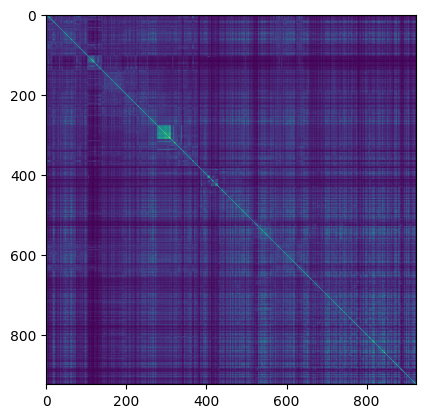

In [15]:
# La cantidad de coincidencias entre las skills de 2 títulos es el producto punto entre sus vectores de skills.
# La matriz de coincidencias entre todos los títulos es una multiplicación matricial
intersec_matrix = X @ X.T
# Para obtener la union de las skills de 2 títulos se debe hacer operaciones or. Se pueden negar (1-X) y luego hacer and (producto).
# Así se obtiene la cantidad de skills que ningún título tiene en común. Se resta a la cantidad total de skills.
union_matrix = X.shape[1] - ((1-X) @ (1-X).T)
# Finalmente, nos interesa la intersección sobre la unión.
iou_matrix = intersec_matrix / np.where(union_matrix == 0, 1, union_matrix)
plt.imshow(iou_matrix)

Se genera el clustering

In [16]:
clus = AgglomerativeClustering(distance_threshold=10, n_clusters=None)
clusters = clus.fit_predict(iou_matrix)

Se visualiza el dendrograma del clustering. 

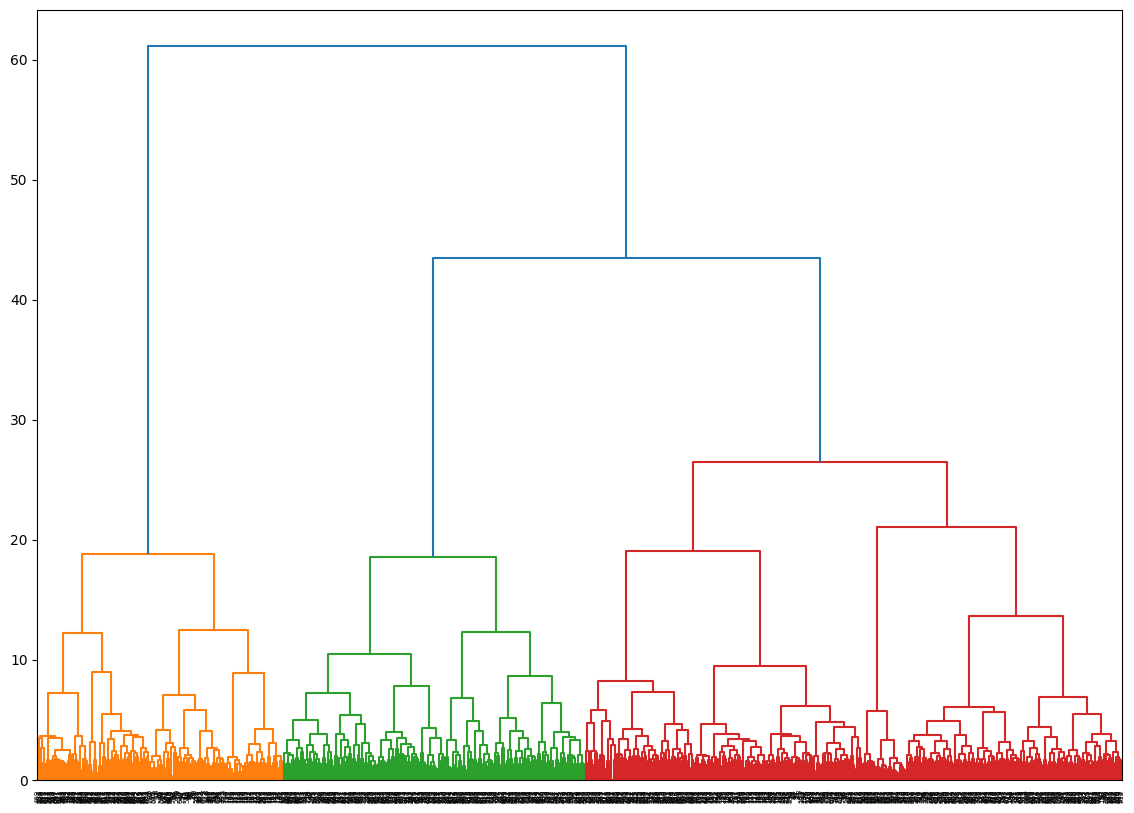

In [17]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize = (14, 10))
plot_dendrogram(clus)

El objetivo de realizar esta visualización es detectar visualmente el umbral de corte de los clusters. Esta heurística es completamente arbitraria. Entre alrededor de 4-5 se observa que se obtienen clusters con sentido. Se re entrena el algoritmo de clustering.

In [18]:
clus = AgglomerativeClustering(distance_threshold=4, n_clusters=None)
clusters = clus.fit_predict(iou_matrix)

Se revisa un ejemplo (cluster al que pertenece data scientist)

In [19]:
all_titles_ind["Data Scientists"]

136

In [20]:
clusters[136]

39

In [21]:
all_titles.loc[clusters == 39]

12        Computer and Information Systems Managers
33           Architectural and Engineering Managers
107    Computer and Information Research Scientists
108            Computer Network Support Specialists
114                    Data Warehousing Specialists
122                              Web Administrators
125                             Penetration Testers
126                  Information Security Engineers
127                      Digital Forensics Analysts
128                            Blockchain Engineers
133                    Operations Research Analysts
136                                 Data Scientists
161                            Validation Engineers
dtype: object

Se observa que "tiene sentido" el clustering, ya que sólo son títulos vinculados a tecnología. Se prueba realizar la heurística sólo con estos empleos.

In [22]:
X_ds = X[all_titles.loc[clusters == 39].index]

In [23]:
br = Branch(None, X_ds[11], np.arange(X_ds.shape[0]), X_ds, salario_promedio[clusters == 39])
br.split(distance = 100)
br.trim()
br.trim()
br.get_money(10)
br.get_size()
br.sort()

In [24]:
show(br)

#### Approach 4: next steps

- Arreglar el bug de los salarios promedio y los nombres de los títulos: Cambian en la visualización si la matriz es un subconjunto de X
- Elegir un umbral de clustering y aplicar el procedimiento del approach 3 de forma recursiva (intra cluster, luego inter cluster)
- Quizá hacer una heurística basada en el árbol? Es decir, elegir un umbral inicial, mostrar los paths locales, luego mostrar el camino para pasar al cluster **más cercano**, con la distancia en skills. Luego, al cluster siguiente, etc.